In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import cv2
import os

In [5]:
IMAGE_SIZE = 32
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/bangla-handwriting/banga_number_vowel",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 41531 files belonging to 21 classes.


In [7]:
class_names = dataset.class_names
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'dirgho_e',
 'dirgho_u',
 'o',
 'oi',
 'ou',
 'ri',
 'rosho_e',
 'rosho_u',
 'shoro_a',
 'shoro_o']

In [8]:
len(dataset)

1298

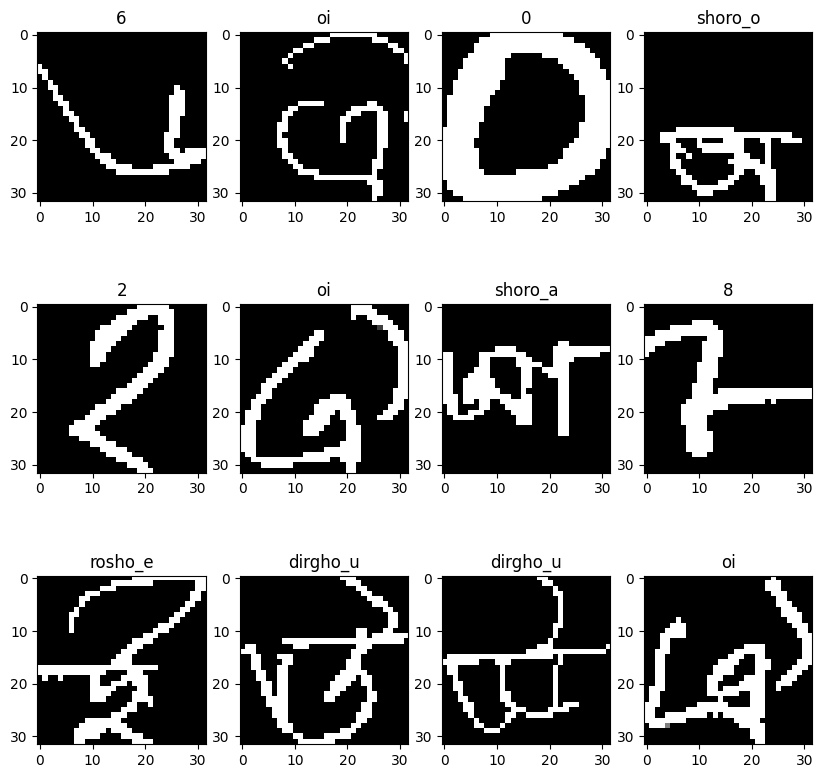

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy())
      plt.title(class_names[label_batch[i]])

In [16]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).take(val_size)


  return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [20]:
len(train_ds)

1038

In [21]:
len(test_ds)

129

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [26]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [28]:
def densenet(img_shape, n_classes, f=32):
    
  repetitions = 6, 12, 24, 16

  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x


  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor


  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x


  input = Input(img_shape)
    
  resize_and_rescale,
  data_augmentation,

  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)

  x = GlobalAvgPool2D()(d)

  output = Dense(n_classes, activation='softmax')(x)

  model = Model(input, output)
  return model

In [32]:
input_shape = IMAGE_SIZE, IMAGE_SIZE, CHANNELS
n_classes = 21

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['max_pooling2d[0][0]']   

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
1038/1038 [==============================] - 358s 345ms/step - loss: 0.2323 - accuracy: 0.9325 - val_loss: 0.3170 - val_accuracy: 0.9162
Epoch 2/10
1038/1038 [==============================] - 364s 351ms/step - loss: 0.2053 - accuracy: 0.9431 - val_loss: 0.1632 - val_accuracy: 0.9586
Epoch 3/10
1038/1038 [==============================] - 364s 351ms/step - loss: 0.1500 - accuracy: 0.9570 - val_loss: 0.1782 - val_accuracy: 0.9520
Epoch 4/10
1038/1038 [==============================] - 361s 348ms/step - loss: 0.1412 - accuracy: 0.9601 - val_loss: 0.1810 - val_accuracy: 0.9508
Epoch 5/10
1038/1038 [==============================] - 361s 348ms/step - loss: 0.1561 - accuracy: 0.9612 - val_loss: 0.1878 - val_accuracy: 0.9545
Epoch 6/10
1038/1038 [==============================] - 374s 361ms/step - loss: 0.0935 - accuracy: 0.9723 - val_loss: 0.1340 - val_accuracy: 0.9622
Epoch 7/10
1038/1038 [==============================] - 366s 353ms/step - loss: 0.0840 - accuracy: 0.9752 - val_

In [49]:
scores = model.evaluate(test_ds)

129/129 [==============================] - 11s 82ms/step - loss: 0.1172 - accuracy: 0.9736


In [50]:
History= history
History

In [51]:
History.params

{'verbose': 1, 'epochs': 10, 'steps': 1038}

In [52]:
History.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

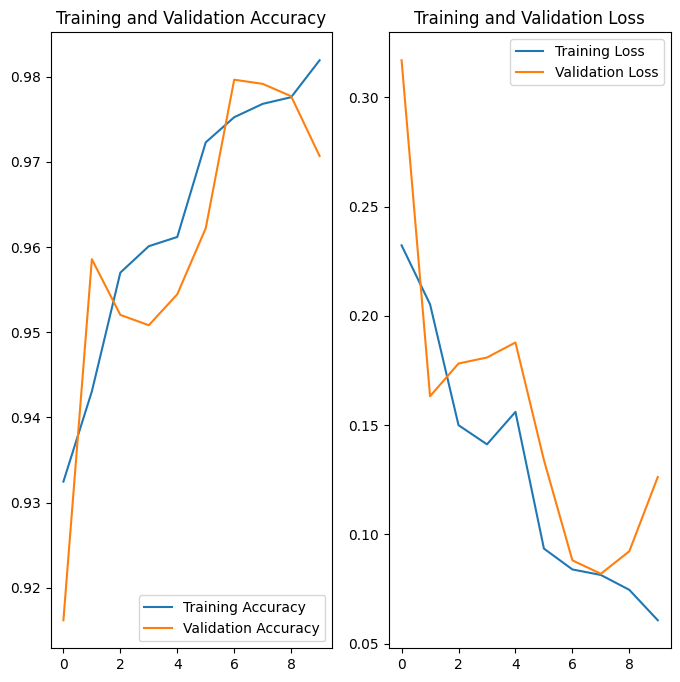

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


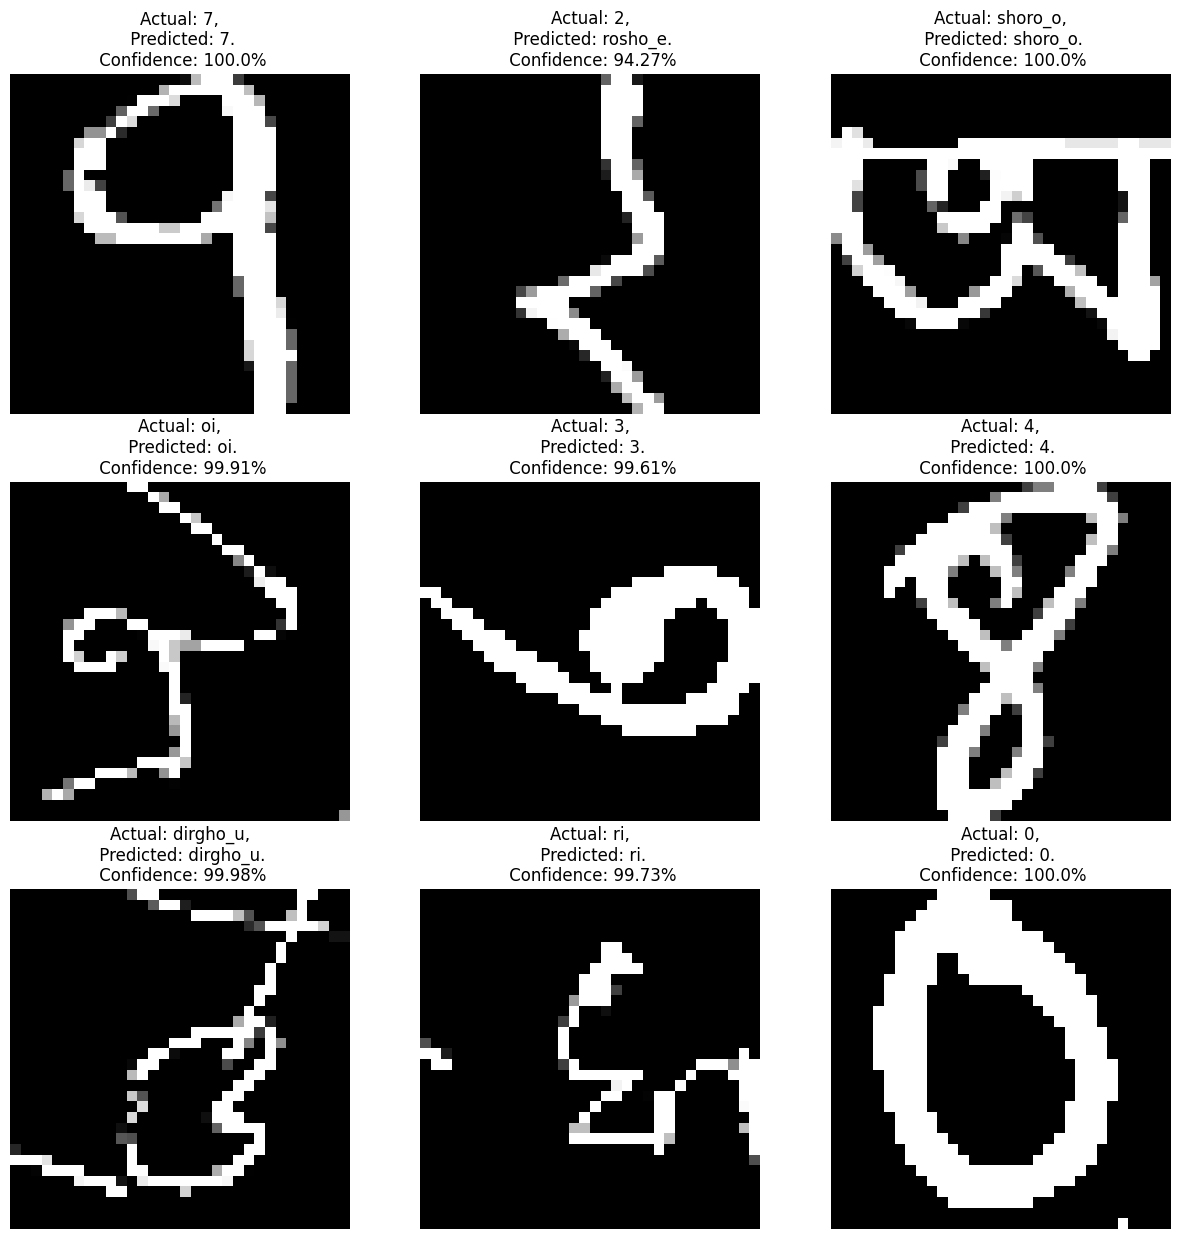

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
from tensorflow.keras.models import load_model
model.save("/kaggle/working/Dense_model_1.tflite")

In [60]:
model.save("/kaggle/working/Dense_model_1.hdf5")

In [61]:
reloaded_model = tf.keras.models.load_model("/kaggle/working/Dense_model_1.tflite")

In [62]:
reloaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['max_pooling2d[0][0]']   

In [63]:
scores = reloaded_model.evaluate(test_ds)

129/129 [==============================] - 14s 85ms/step - loss: 0.1172 - accuracy: 0.9736
